# LOF(局所外れ値度法)の実装例
* scikit-learnのライブラリにあるため、それを利用する。

In [14]:
# !pip install japanize-matplotlib

In [4]:
import numpy as np
import pandas as pd
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import shap

# 正規分布データに対する適用例

In [5]:
# ダミーデータ作成
np.random.seed(42)

# 変数生成
ph = np.round(np.random.uniform(4, 10, 2000), 1)          # ph: 4~10, 小数点1桁
water_temp = np.round(np.random.uniform(10, 60, 2000), 0) # water_temp: 10~60, 小数点0桁
rain = np.round(np.random.uniform(0, 100, 2000), 0)       # rain: 0~100, 小数点0桁
cod = np.round(np.random.uniform(0, 10, 2000), 1)         # COD: 0~10, 小数点1桁

data_df = pd.DataFrame({
    'ph': ph,
    'water_temp': water_temp,
    'rain': rain,
    'cod': cod
})

# 正常範囲データ抽出
sampled_data = data_df[
    (data_df['ph'] >= 6) &
    (data_df['ph'] <= 10) &
    (data_df['water_temp'] <= 35) &
    (data_df['rain'] <= 25) &
    (data_df['cod'] <= 5)
]
sampled_data.describe()

,ph,water_temp,rain,cod
count,98.000000,98.000000,98.000000,98.000000
mean,7.875510,23.255102,13.142857,2.423469
std,1.174827,7.757020,7.539586,1.486420
min,6.000000,10.000000,0.000000,0.000000
25%,6.900000,16.250000,7.000000,1.000000
50%,7.800000,23.000000,14.000000,2.350000
75%,8.750000,30.000000,19.000000,3.700000
max,10.000000,35.000000,25.000000,4.900000


In [8]:
# 標準化
scaler = StandardScaler()
df_scaled = scaler.fit_transform(sampled_data)
df_scaled = pd.DataFrame(df_scaled, columns=sampled_data.columns)

# 正常データでLOFモデルを作る
# novelty=Trueで、未知データ評価できる
# ※ n_neighborsはパラメータなので、試行錯誤必要
#    パラメータの試行錯誤は、データ量に合わせて考える（データ量少ないのに、neighbors大きくしたら、全体の分布に引っ張られる）
lof = LocalOutlierFactor(n_neighbors=5, novelty=True)
# lof.fit(df)
lof.fit(df_scaled)

LocalOutlierFactor(n_neighbors=5, novelty=True)

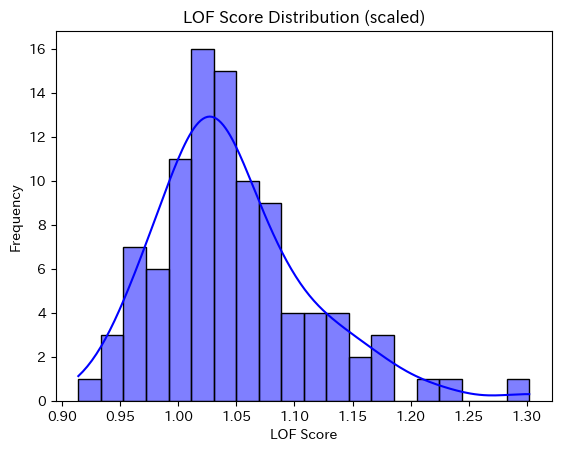

In [9]:
# 正常データのLOFスコア分布確認
lof_scores = -lof.negative_outlier_factor_
sns.histplot(lof_scores, kde=True, bins=20, color="blue")
plt.title("LOF Score Distribution (scaled)")
plt.xlabel("LOF Score")
plt.ylabel("Frequency")
plt.show()

* 訓練データでのLOFスコアの分布が1近辺に集中していれば、正常空間として問題ない。

In [10]:
# 判別対象レコードのデータフレーム作成
target_df = pd.DataFrame({
    'ph': [2, 7, 8, 7, 7],
    'water_temp': [30, 55, 24, 55, 25],
    'rain': [0, 0, 80, 0, 0],
    'cod': [2, 1, 1, 10, 1]
})
anomaly_candidates = target_df.values

In [13]:
# 異常判定データのスケーリング
scaled_anomaly_candidates = scaler.transform(anomaly_candidates)

# 異常判定
predictions = lof.predict(scaled_anomaly_candidates)
lof_scores_candidates = lof.decision_function(scaled_anomaly_candidates)

# 結果格納
result = pd.DataFrame({
    'LOF_score': lof_scores_candidates,
    '異常判定結果': predictions,
    '正解値': ['異常', '異常','異常','異常','正常']
})
result

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


,LOF_score,異常判定結果,正解値
0,-1.236680,-1,異常
1,-1.542142,-1,異常
2,-3.955638,-1,異常
3,-1.722526,-1,異常
4,0.403391,1,正常


* 正常データで判別空間を作成すると、LOFスコアの閾値は0となる。異常かどうかの判別は、LOFスコアが0以上なら正常、0未満なら異常と判別される。
* 異常判定は全て正解したが、どの要素が異常原因となっているかの判断ができないため、以下でSHAPを用いて異常原因の特定を行う。

### SHAPによる異常原因の特定

In [16]:
def lof_predict(data):
    return lof.decision_function(data)

explainer = shap.Explainer(lof_predict, df_scaled)

# 判定対象のSHAP値を計算
shap_values = explainer(scaled_anomaly_candidates)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid


データポイント 1: [ 2 30  0  2]


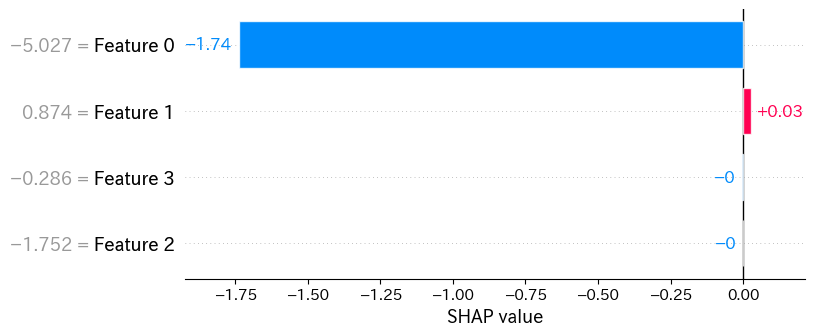


データポイント 2: [ 7 55  0  1]


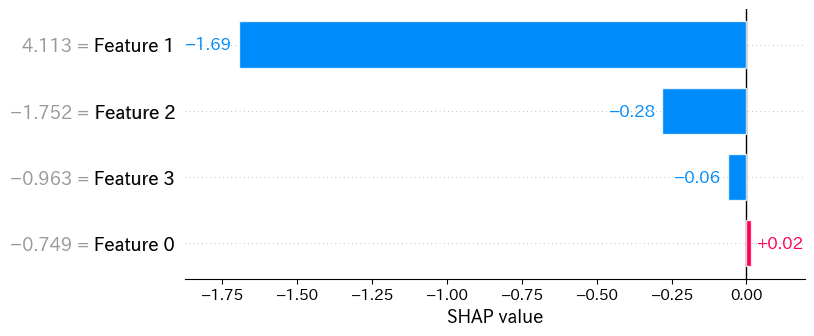


データポイント 3: [ 8 24 80  1]


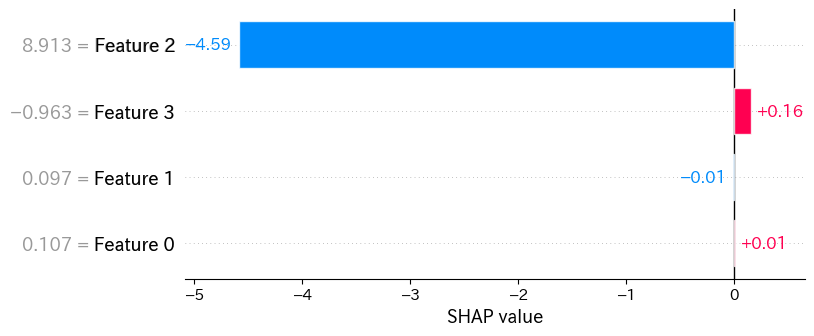


データポイント 4: [ 7 55  0 10]


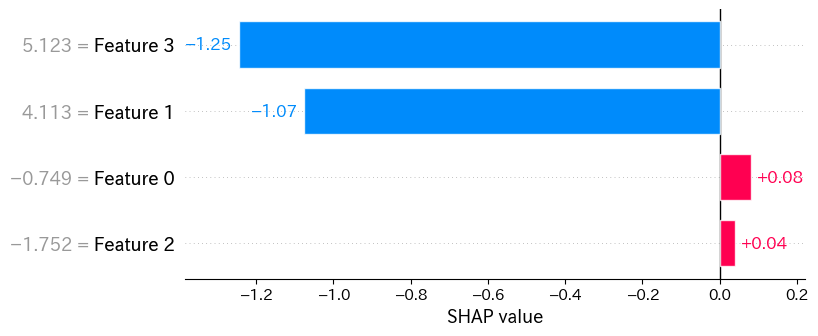


データポイント 5: [ 7 25  0  1]


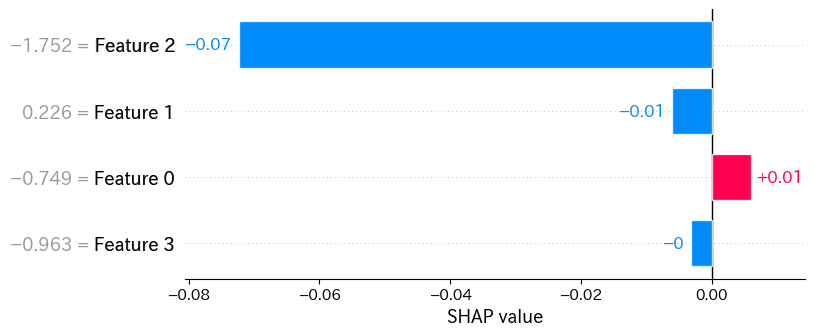

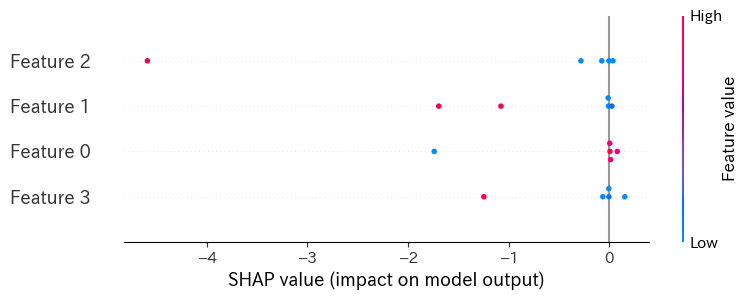

In [19]:
# 5. SHAP値の可視化
# 寄与度を棒グラフで表示
for i, data_point in enumerate(anomaly_candidates):
    print(f"\nデータポイント {i+1}: {data_point}")
    shap.plots.bar(shap_values[i], show=True)

# 6. 特徴量の全体的な重要度を可視化
shap.summary_plot(shap_values, scaled_anomaly_candidates)


* SHAPを使うことで、どの変数が異常値の原因となっているか特定できる。

# 非正規分布データに対する適用例

In [ ]:
import numpy as np
import pandas as pd
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

In [ ]:
# 正常データの用意
data_path = "/content/drive/MyDrive/異常検知/data/Davis_1_2.csv"
ori_df = pd.read_csv(data_path)
df = ori_df.loc[:, ["weight", "height"]]
df1 = df.loc[(df['height'] < 130) & (df['weight'] > 25) & (df['weight'] < 45)]
df2 = df.loc[(df['height'] > 140) & (df['height'] < 190) & (df['weight'] > 50) & (df['weight'] < 80)]
df = pd.concat([df1, df2], ignore_index=True)
df.head()

,weight,height
0,31,118
1,35,118
2,40,115
3,31,116
4,34,118


<Axes: xlabel='weight', ylabel='height'>

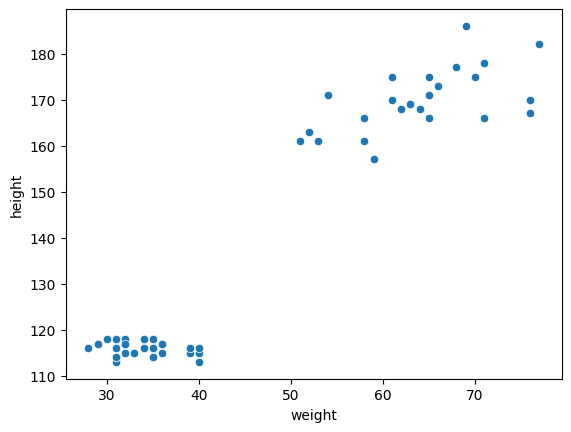

In [ ]:
# 分布チェック
sns.scatterplot(x="weight", y="height", data=df)

## 補：LocalOutlierFactorクラスのパラメータ
| パラメータ         | 説明                                                                                      | デフォルト値 |
|--------------------|-----------------------------------------------------------------------------------------|------------|
| `n_neighbors`      | LOF計算に使用する近傍点の数 (\(k\)-近傍)。小さすぎると局所性が強調され、大きすぎるとグローバルに近くなる。 | 20         |
| `algorithm`        | 近傍探索に使用するアルゴリズム。`'auto'`, `'ball_tree'`, `'kd_tree'`, `'brute'` を指定可能。 | `'auto'`   |
| `metric`           | 距離計算の基準（例: `'euclidean'`, `'manhattan'`）。                                     | `'minkowski'` |
| `contamination`    | データセット中の異常値の割合（0から1の値）。                                               | `'auto'`   |
| `novelty`          | 未知のデータ（新しいデータポイント）の異常検知に対応するかを指定（`True` または `False`）。 | `False`    |
| `n_jobs`           | 並列処理に使用するCPUコアの数。`-1` を指定すると全コア使用。                              | `None`     |


In [ ]:
# 標準化
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, columns=["weight", "height"])

# 正常データでLOFモデルを作る
# novelty=Trueで、未知データ評価できる
# ※ n_neighborsはパラメータなので、試行錯誤必要
#    パラメータの試行錯誤は、データ量に合わせて考える（データ量少ないのに、neighbors大きくしたら、全体の分布に引っ張られる）
lof = LocalOutlierFactor(n_neighbors=10, novelty=True)
# lof.fit(df)
lof.fit(df_scaled)

LocalOutlierFactor(n_neighbors=10, novelty=True)

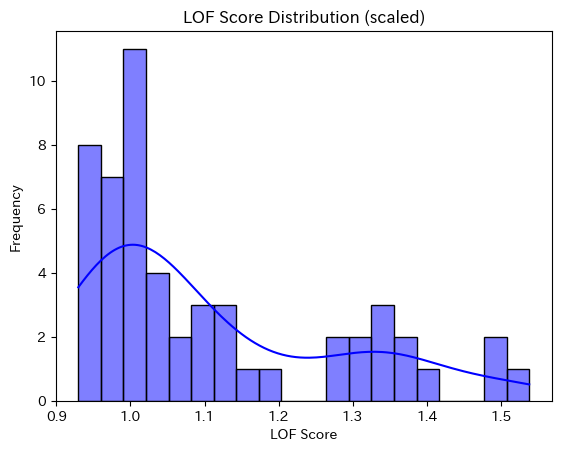

In [ ]:
# 正常データのLOFスコア分布確認
lof_scores = -lof.negative_outlier_factor_
sns.histplot(lof_scores, kde=True, bins=20, color="blue")
plt.title("LOF Score Distribution (scaled)")
plt.xlabel("LOF Score")
plt.ylabel("Frequency")
plt.show()

In [ ]:
# 異常判定データの用意
anomaly_candidates = np.array([
    # ["weight", "height"]
    [24, 113], # 異常
    [35, 115], # 正常
    [40, 125], # 異常
    [42, 160], # 異常
    [70, 180], # 正常
    [80, 197], # 異常
    [95, 185], # 異常
])

# 異常判定データのスケーリング
scaled_anomaly_candidates = scaler.transform(anomaly_candidates)

# 異常判定
predictions = lof.predict(scaled_anomaly_candidates)
lof_scores_candidates = lof.decision_function(scaled_anomaly_candidates)
# predictions = lof.predict(anomaly_candidates)
# lof_scores_candidates = lof.decision_function(anomaly_candidates)

print("異常判定結果:", predictions)
print("判定対象データのLOFスコア:", lof_scores_candidates)

異常判定結果: [-1  1 -1 -1  1 -1 -1]
判定対象データのLOFスコア: [-1.04651512  0.48922395 -0.44183718 -0.48993229  0.40920867 -0.52575925
 -1.52530794]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


#### lof.decision_function()について
* テストデータ用のlofスコア算出関数
* スコアが0に近いほど正常であることを示す
* スコアが負の値に近づくほど異常度が高いことを示す




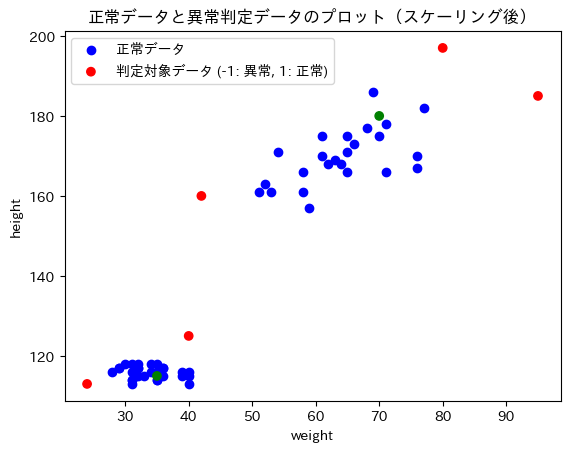

In [ ]:
# 6) 正常データと異常値判定データをプロット
plt.scatter(df.iloc[:, 0], df.iloc[:, 1], color='blue', label='正常データ')
plt.scatter(anomaly_candidates[:, 0], anomaly_candidates[:, 1],
            c=['red' if p == -1 else 'green' for p in predictions],
            label='判定対象データ (-1: 異常, 1: 正常)')
plt.legend()
plt.title("正常データと異常判定データのプロット（スケーリング後）")
plt.xlabel("weight")
plt.ylabel("height")
plt.show()

* プロットのように、クラスターの密度に合わせて異常判定する距離が変わっていることがわかる。
    * 左下のグループは、密集度が濃いので、異常判定する距離が短い
    * 一方で、右上のグループでは、密集度が低いので、異常判定する距離が長い

##  lof.predict(anomaly_candidates)で異常判定を行うメカニズム
`lof.predict(anomaly_candidates)`で異常判定を行う際の基準は、`decision_function(anomaly_candidates)`が返す LOFスコアの値 をもとにしている。

### 1. `predict`メソッドの動作
`predict`メソッドは、対象データ（例: anomaly_candidates）に対して以下のように異常か正常かを判定する：
* 判定結果:
    * **1**: 正常値
    * **2**: 異常値
* 判定基準:
    * 内部的には`decision_function(anomaly_candidates)`のスコアを計算する。
    * スコアが >= 0 の場合は**正常値(1)**
    * スコアが < 0 の場合は**異常値(0)**

### 2. `decision_function`との異常判定の関係
- 正常値:
  - `decision_function` のスコアが $ \geq 0 $ の場合。
  - 通常はスコアが \( 0.0 \) に近いか、わずかに正の値。

- 異常値:
  - `decision_function` のスコアが \( < 0 \) の場合。
  - スコアが負であるほど異常度が高い。

---

### 3. 異常判定の基準のカスタマイズ

デフォルトではスコア \( 0 \) を基準にしていますが、異常判定の基準をカスタマイズしたい場合は、`decision_function` を利用して手動で閾値を設定できる。

#### **カスタマイズ例**
```python
# LOFスコアを取得
lof_scores = lof.decision_function(anomaly_candidates)

# カスタム閾値
threshold = -0.5  # 例: スコア -0.5 を閾値に設定

# スコアに基づく異常判定
custom_predictions = np.where(lof_scores < threshold, -1, 1)
print("カスタム閾値での異常判定:", custom_predictions)
```

---

### 4. なぜスコア \(0\) を基準にしているのか？

スコア \(0\) を基準にする理由は、LOFスコアが正常なデータと異常なデータの境界を自然に表現するから：

1. **LOFスコアの直感的な解釈**:
   - 正常データのスコアは $ \approx 0 $ に集中する。
   - 異常データは \( < 0 \) に離れたスコアを持つことが一般的。

2. **適応性**:
   - 正常データの分布に応じてスコア \(0\) が基準となるため、異常判定がデータ分布に自動的に適応する。
